In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from analysis_functions import *
from model_functions import *
import matplotlib.patches as patches
import seaborn as sns
import scipy.stats as stats
from scipy.stats import shapiro, chi2, mannwhitneyu, ttest_ind

# Read extraced variables into csv

In [27]:
Vars = pd.read_csv('Saved_data/GCaMP_closedopenMM_all_470_stats_df.csv')
sensor = 'GCaMP'
#Vars = pd.read_csv('GRAB_MM_extracted_vars.csv')
#sensor = 'GRAB'
Vars

,session,block_type,mouse_id,event_time,movementX_prior,movementY_prior,time_range,valid_data,peak,mean,median,stderr,halt
0,session 1,closedloop,B3M3,95.818,14.744543,2.121528,-1-0s,True,1.475076,-0.001464,0.158885,0.023800,True
1,session 1,closedloop,B3M3,95.818,14.744543,2.121528,0-1s,True,5.315242,1.509365,1.309904,0.086313,True
2,session 1,closedloop,B3M3,95.818,14.744543,2.121528,1-2s,True,5.275810,3.832685,3.898209,0.021136,True
3,session 1,closedloop,B3M3,118.352,15.799878,2.204030,-1-0s,True,3.709250,-0.000857,0.109697,0.062860,True
4,session 1,closedloop,B3M3,118.352,15.799878,2.204030,0-1s,True,1.542921,0.064895,0.139069,0.021871,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,session 2,openloop,B3M3,1812.040,-0.093984,0.317783,0-1s,True,1.251757,-0.166572,-0.354865,0.022298,False
506,session 2,openloop,B3M3,1812.040,-0.093984,0.317783,1-2s,True,10.747248,2.588257,-0.264668,0.137419,False
507,session 2,openloop,B3M3,1857.821,21.159917,2.824267,-1-0s,True,2.292401,-0.001689,0.137534,0.048282,False
508,session 2,openloop,B3M3,1857.821,21.159917,2.824267,0-1s,True,-0.100854,-1.517470,-1.656679,0.020027,False


# Make boxplots to view difference in params for halts and no-halts 

In [28]:
#Look at halt data for 0 to 1 second after halt
halt_data_during = Vars.loc[Vars.halt == True].loc[Vars.time_range == '0-1s']
halt_data_during.describe() 

,event_time,movementX_prior,movementY_prior,peak,mean,median,stderr
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,684.725280,15.469190,1.981770,3.102748,1.083245,1.142435,0.038174
std,503.477261,6.484454,0.951190,2.251480,2.011446,2.080527,0.016877
min,95.818000,-0.362377,-0.482220,-1.493026,-3.136345,-3.511195,0.017985
25%,317.933000,13.891035,1.843951,1.688077,0.064895,0.139069,0.023188
50%,614.847000,16.757349,2.258609,3.084253,1.509365,1.612630,0.035822
75%,841.444000,19.652427,2.564559,4.306646,1.937671,2.295876,0.047601
max,1866.951000,23.847944,3.145091,8.007807,5.627188,5.215740,0.086313


In [29]:
#Look at halt data for 0 to 1 second after the non-halt
Nohalt_data_during = Vars.loc[Vars.halt == False].loc[Vars.time_range == '0-1s']
Nohalt_data_during.describe() 

,event_time,movementX_prior,movementY_prior,peak,mean,median,stderr
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,867.387000,13.619280,1.890190,1.526633,-0.256153,-0.332926,0.025160
std,506.465466,7.393735,1.008326,2.284165,1.757486,1.721201,0.015698
min,38.365000,-0.196126,-0.179721,-2.939829,-4.114176,-4.269046,0.011213
25%,505.836750,10.252260,1.461040,0.346642,-1.172444,-1.263271,0.015442
50%,779.403000,15.724227,2.147791,1.015211,-0.459359,-0.479851,0.021153
75%,1296.657500,18.573750,2.616737,1.902302,0.328454,0.241921,0.026354
max,1857.821000,29.322797,3.670428,9.697614,5.575705,4.933945,0.081313


## Plotting params for individual mice

In [44]:
def compare_statistics_grid(data, statistics, time_range):
    """
    Generate a grid of boxplots comparing the distribution of selected statistics 
    for `halt=True` and `halt=False`.

    Parameters:
    - data (pd.DataFrame): The dataset containing statistics and halt information.
    - statistics (list): List of statistics to compare (e.g., ['peak', 'mean', 'stderr']).
    - time_range (str): The time range to filter data (e.g., '0-1s').
    """
    # Filter the data for the specified time range
    filtered_data = data[data['time_range'] == time_range]
    
    if filtered_data.empty:
        print(f"No data available for the time range: {time_range}")
        return

    # Create a grid of plots
    num_stats = len(statistics)
    cols = 3 if num_stats > 2 else 2
    rows = (num_stats + cols - 1) // cols  # Compute rows based on number of plots and columns
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()

    # Loop through each statistic and create a boxplot
    for i, stat in enumerate(statistics):
        sns.boxplot(
            data=filtered_data, 
            x='halt', 
            y=stat, 
            hue='halt', 
            ax=axes[i], 
            palette=['#FF9999', '#66B2FF'], 
            dodge=False
        )
        axes[i].set_title(f'{stat.capitalize()} Comparison\n(Time Range: {time_range})', fontsize=14)
        axes[i].set_xlabel('Halt', fontsize=12)
        axes[i].set_ylabel(stat.capitalize(), fontsize=12)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].get_legend().remove()  # Remove individual legends

    # Remove unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()




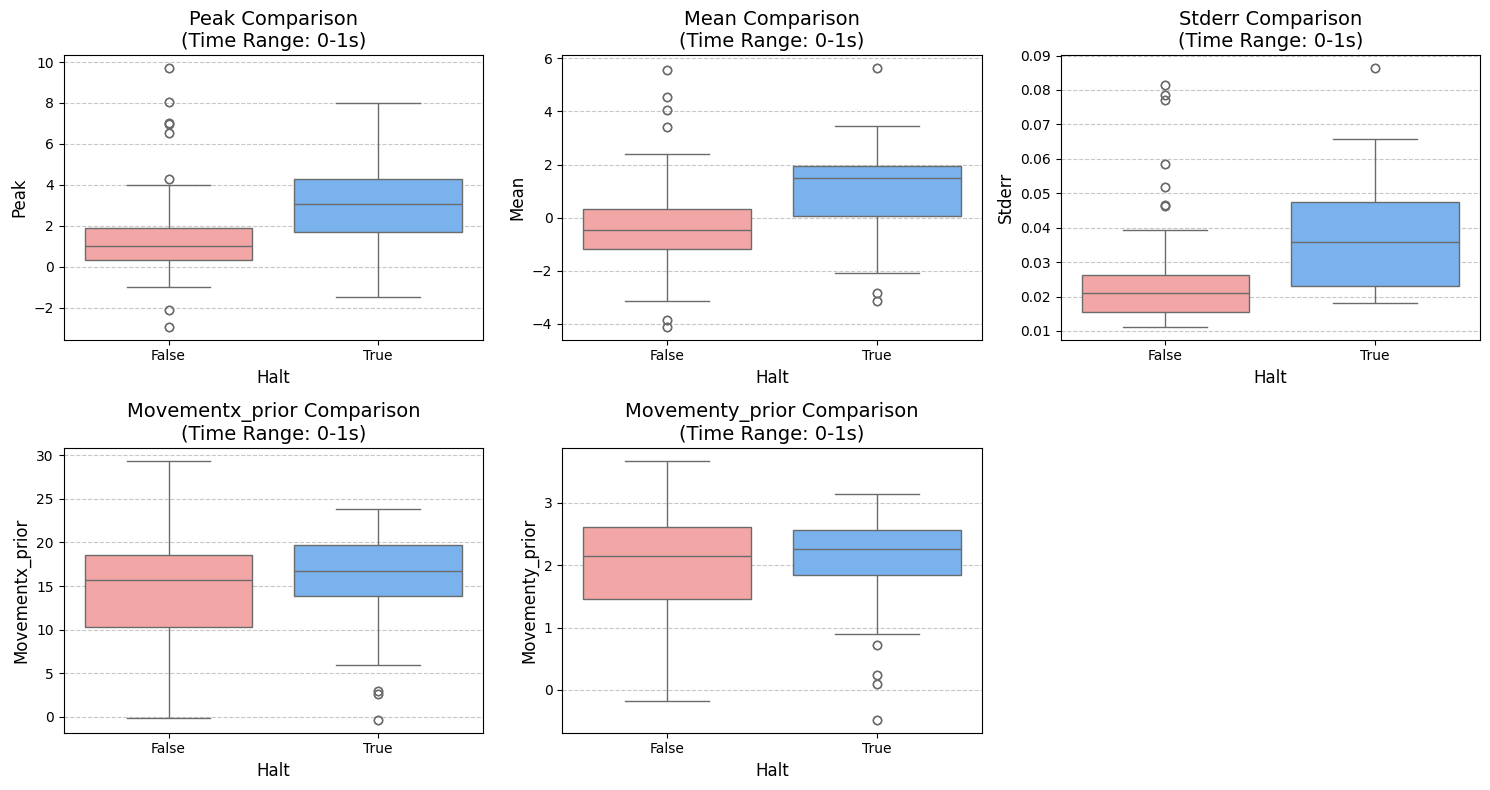

In [45]:
# List of statistics to compare
statistics_to_compare = ['peak', 'mean', 'stderr', 'movementX_prior']

# Generate the grid of boxplots for the time range '0-1s'
compare_statistics_grid(mousedata, statistics=statistics_to_compare, time_range='0-1s')



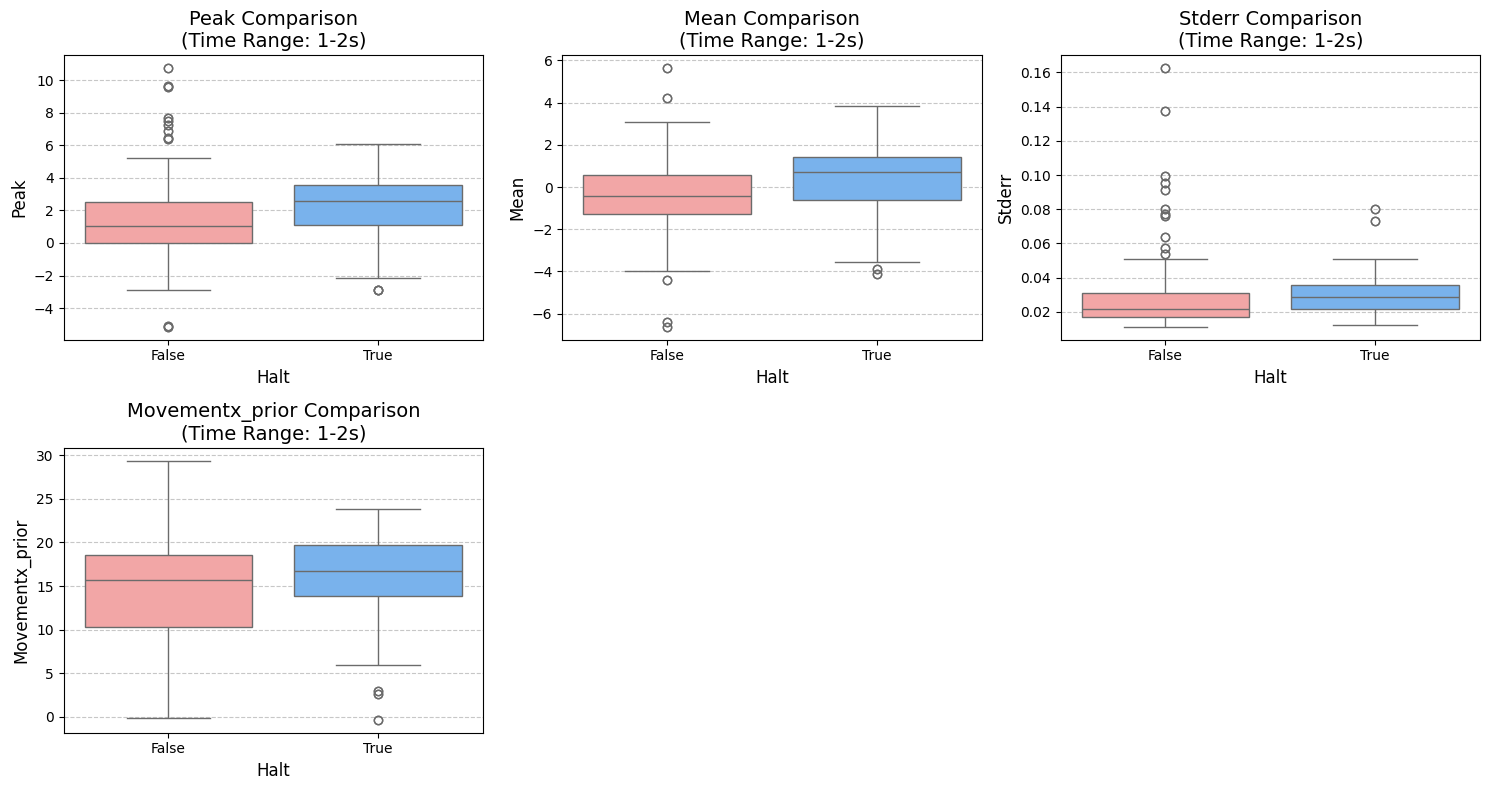

In [46]:
# List of statistics to compare
statistics_to_compare = ['peak', 'mean', 'stderr', 'movementX_prior']

# Generate the grid of boxplots for the time range '0-1s'
compare_statistics_grid(mousedata, statistics=statistics_to_compare, time_range='1-2s')

In [47]:
# Grouping by relevant columns and aggregating the desired statistics
mouse_means = (
    mousedata.groupby(['mouse_id', 'halt', 'block_type', 'session', 'time_range'])
    .agg({
        'peak': 'mean',  # Mean peak response for each group
        'mean': 'mean',  # Mean response for each group
        'stderr': 'mean',  # Mean standard error for each group
        'movementX_prior': 'mean',  # Mean movementX_prior
        'movementY_prior': 'mean',  # Mean movementY_prior
    })
    .reset_index()  # Reset index for easier handling
)

# Displaying the result
mouse_means.head()


,mouse_id,halt,block_type,session,time_range,peak,mean,stderr,movementX_prior,movementY_prior
0,B3M3,False,closedloop,session 1,-1-0s,2.083627,0.000145,0.033694,13.803164,2.007094
1,B3M3,False,closedloop,session 1,0-1s,1.781550,0.008148,0.024983,13.803164,2.007094
2,B3M3,False,closedloop,session 1,1-2s,1.744627,-0.330842,0.031608,13.803164,2.007094
3,B3M3,False,closedloop,session 2,-1-0s,2.083627,0.000145,0.033694,13.803164,2.007094
4,B3M3,False,closedloop,session 2,0-1s,1.781550,0.008148,0.024983,13.803164,2.007094


## Plotting all mouse averages togheter

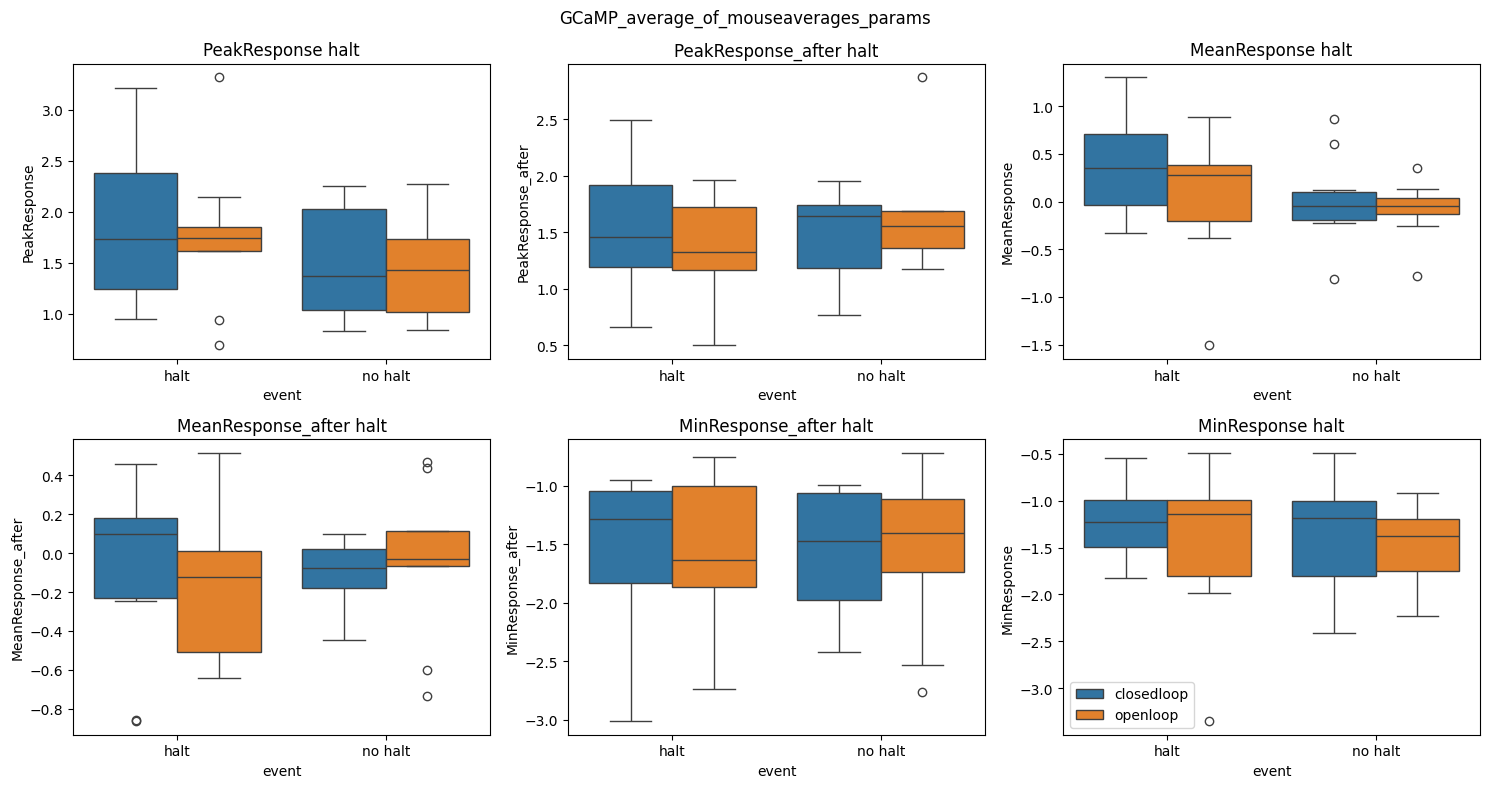

In [206]:
fig, ax = plt.subplots(2,3, figsize = (15, 8))
ax = ax.flatten()

i = 0
for response_col in mouse_means:
    if 'Response' in response_col:
        
        sns.boxplot(x="event", y=response_col, data=mouse_means, hue="SessionBlock", ax=ax[i])
        ax[i].set_title(f"{response_col} halt")
        ax[i].get_legend().remove()
    
        i+=1
plt.legend()
fig.suptitle(f'{sensor}_average_of_mouseaverages_params')

fig.tight_layout(pad=1.08)
fig.savefig(f'Figures/{sensor}_halt_nohalt_boxplot.png', format = 'png')


In [ ]:
## Testing the response difference in the halt and control condition

In [207]:
def testing_diff_control(main_df, control_df):
    #testing normality
    shapiro_main = shapiro(main_df)
    shapiro_control= shapiro(control_df)

    print("Shapiro-Wilk test for halt:", shapiro_main)
    print("Shapiro-Wilk test for no halt:", shapiro_control)

    if (shapiro_main.pvalue < 0.05) or (shapiro_control.pvalue < 0.05):
        print('\n Datasets are normally distributed, will perform t-test \n')
        t_stat, p_val = ttest_ind(main_df, control_df, equal_var=False)
        print(f"T-test: t-statistic={t_stat}, p-value={p_val}")
    else:
        print('\n At least one dataset is not normally distributed, will perform Mann–Whitney U test \n')
        u_stat, p_val = mannwhitneyu(main_df, control_df, alternative='two-sided')
        print(f"Mann-Whitney U test: U-statistic={u_stat}, p-value={p_val}")

    mean_diff = np.mean(main_df) - np.mean(control_df)
    pooled_std = np.sqrt((np.std(main_df, ddof=1)**2 + np.std(control_df, ddof=1)**2) / 2)
    cohens_d = mean_diff / pooled_std
    print(f"Cohen's d: {cohens_d}")

In [208]:
halt_mean_response = mouse_means.loc[mouse_means['event'] == 'halt', 'MeanResponse']
no_halt_mean_response = mouse_means.loc[mouse_means['event'] == 'no halt', 'MeanResponse']

testing_diff_control(halt_mean_response, no_halt_mean_response)

Shapiro-Wilk test for halt: ShapiroResult(statistic=np.float64(0.9430678433978182), pvalue=np.float64(0.2992445824847423))
Shapiro-Wilk test for no halt: ShapiroResult(statistic=np.float64(0.9163908996055667), pvalue=np.float64(0.09706069164347156))

 At least one dataset is not normally distributed, will perform Mann–Whitney U test 

Mann-Whitney U test: U-statistic=241.0, p-value=0.07982801677674653
Cohen's d: 0.4933152975444798


In [210]:
halt_peak_response = mouse_means.loc[mouse_means['event'] == 'halt', 'PeakResponse']
no_peak_mean_response = mouse_means.loc[mouse_means['event'] == 'no halt', 'PeakResponse']

testing_diff_control(halt_peak_response, no_peak_mean_response)

Shapiro-Wilk test for halt: ShapiroResult(statistic=np.float64(0.9352703582382496), pvalue=np.float64(0.21640192773633476))
Shapiro-Wilk test for no halt: ShapiroResult(statistic=np.float64(0.8873186158107463), pvalue=np.float64(0.02885539091837722))

 Datasets are normally distributed, will perform t-test 

T-test: t-statistic=1.7423268862503134, p-value=0.09105073178631214
Cohen's d: 0.5652854871237246


## Fitting Linear Mixed-Effects Model
Response = β0 +β1 ⋅moveX+β2 ⋅moveY+β3 ⋅event+β4 ⋅SessionBlock+β5 ⋅ moveX:SessionBlock+u MouseID + ϵ

In [238]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "MeanResponse ~ moveX + event + SessionBlock + moveX:SessionBlock",
    data=Vars,
    groups=Vars["MouseID"]
)
result = model.fit()
print(result.summary())


                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      MeanResponse
No. Observations:      709          Method:                  REML        
No. Groups:            5            Scale:                   2.1436      
Min. group size:       123          Log-Likelihood:          -1275.7950  
Max. group size:       160          Converged:               Yes         
Mean group size:       141.8                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.508    0.207  2.454 0.014  0.102  0.913
event[T.no halt]               -0.313    0.114 -2.752 0.006 -0.536 -0.090
SessionBlock[T.openloop]       -0.161    0.211 -0.762 0.446 -0.575  0.253
moveX                          -1.904    1.918 -0.993 0.

/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [236]:
print(Vars["MouseID"].value_counts())
print(Vars.groupby("MouseID")[["moveX", "moveY"]].std())


MouseID
B3M2    160
B3M3    156
B3M1    142
B2M4    128
B2M5    123
Name: count, dtype: int64
            moveX     moveY
MouseID                    
B2M4     0.038303  0.004382
B2M5     0.052174  0.006011
B3M1     0.045799  0.133370
B3M2     0.033707  0.005522
B3M3     0.071230  0.009704


In [239]:
# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "PeakResponse ~ moveX + event + SessionBlock + moveX:SessionBlock",
    data=Vars,
    groups=Vars["MouseID"]
)
result = model.fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      PeakResponse
No. Observations:      709          Method:                  REML        
No. Groups:            5            Scale:                   3.0510      
Min. group size:       123          Log-Likelihood:          -1404.0320  
Max. group size:       160          Converged:               Yes         
Mean group size:       141.8                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       2.100    0.275  7.631 0.000  1.561  2.640
event[T.no halt]               -0.388    0.136 -2.857 0.004 -0.655 -0.122
SessionBlock[T.openloop]       -0.260    0.253 -1.028 0.304 -0.756  0.236
moveX                          -2.629    1.875 -1.402 0.

In [243]:
# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "MeanResponse ~ event",
    data=Vars,
    groups=Vars["MouseID"]
)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: MeanResponse
No. Observations:  709     Method:             REML        
No. Groups:        5       Scale:              2.1539      
Min. group size:   123     Log-Likelihood:     -1280.7675  
Max. group size:   160     Converged:          Yes         
Mean group size:   141.8                                   
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.273    0.094  2.911 0.004  0.089  0.458
event[T.no halt] -0.322    0.114 -2.832 0.005 -0.546 -0.099
Group Var         0.004    0.009                           



/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


## Look at halt data alone - especially if significantly different from no halt data

In [244]:
halt_data = Vars.loc[Vars['event'] == 'halt']

In [246]:
# Fit Linear Mixed-Effects Model
model = smf.mixedlm(
    "PeakResponse ~ moveX + SessionBlock + moveX:SessionBlock",
    data=halt_data,
    groups=halt_data["MouseID"]
)
result = model.fit()
print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      PeakResponse
No. Observations:       271          Method:                  REML        
No. Groups:             5            Scale:                   3.3154      
Min. group size:        48           Log-Likelihood:          -545.0030   
Max. group size:        62           Converged:               Yes         
Mean group size:        54.2                                              
--------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------
Intercept                       1.710    0.374  4.576 0.000   0.977  2.442
SessionBlock[T.openloop]        0.382    0.423  0.903 0.367  -0.448  1.212
moveX                           1.807    3.235  0.559 0.576  -4.533  8.148
moveX:SessionBlock[T.openloop] -7.930    4.2

In [247]:
#Fit a variable at a time
response_running = smf.ols('MeanResponse ~ moveX + moveX:SessionBlock', data=halt_data).fit()

print(response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

                            OLS Regression Results                            
Dep. Variable:           PeakResponse   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.080
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.127
Time:                        13:26:05   Log-Likelihood:                -549.69
No. Observations:                 271   AIC:                             1105.
Df Residuals:                     268   BIC:                             1116.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [259]:
closedloop_data = halt_data.loc[halt_data.SessionBlock == 'closedloop']

cloop_response_running = smf.ols('MeanResponse ~ moveX', data=closedloop_data).fit()

print(cloop_response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

openloop_data = halt_data.loc[halt_data.SessionBlock == 'openloop']

oloop_response_running = smf.ols('MeanResponse ~ moveX', data=openloop_data).fit()

print(oloop_response_running.summary())
#print(response_running.t_test('PeakResponse'))
print("MSE=%.3f" % response_running.mse_resid)

                            OLS Regression Results                            
Dep. Variable:           MeanResponse   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.604
Date:                Thu, 12 Dec 2024   Prob (F-statistic):              0.207
Time:                        13:34:51   Log-Likelihood:                -336.28
No. Observations:                 180   AIC:                             676.6
Df Residuals:                     178   BIC:                             683.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0804      0.262      0.307      0.7

In [277]:
for key, item in {'closedloop': [cloop_response_running, closedloop_data],'openloop': [oloop_response_running, openloop_data] }.items():
    print(item)

[<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x190747980>,     SessionNumber SessionBlock MouseID  EventTime     moveX     moveY  \
438     session 1   closedloop    B2M5    106.104  0.055581  0.004784   
439     session 1   closedloop    B2M5    212.120  0.090729  0.009288   
440     session 1   closedloop    B2M5    313.886  0.103850  0.009088   
441     session 1   closedloop    B2M5    373.535  0.091787  0.011181   
442     session 1   closedloop    B2M5    402.552  0.086683  0.011828   
..            ...          ...     ...        ...       ...       ...   
665     session 2   closedloop    B3M2    720.996  0.120503  0.011156   
666     session 2   closedloop    B3M2    795.395  0.108638  0.015268   
667     session 2   closedloop    B3M2    918.094  0.103326  0.014060   
668     session 2   closedloop    B3M2    946.627  0.131907  0.016937   
669     session 2   closedloop    B3M2    963.610  0.121663  0.015982   

     PeakResponse  MinResponse  Mean

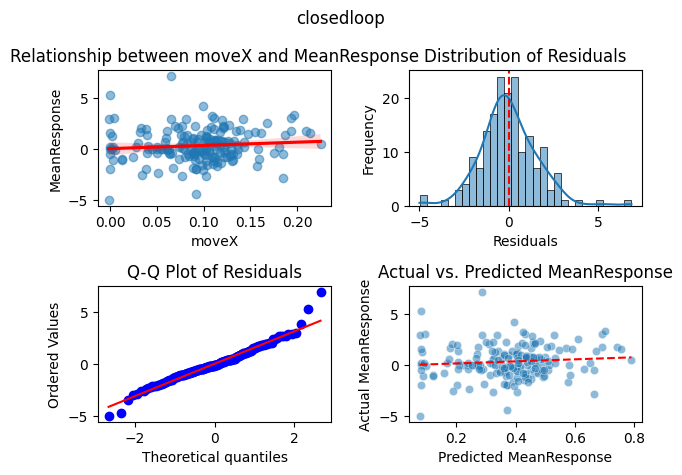

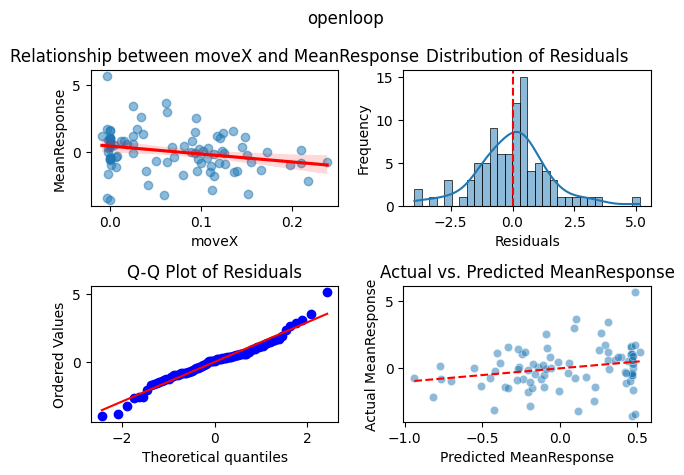

In [281]:
#plotting closed loop
block_result_dict = {'closedloop': [cloop_response_running, closedloop_data],'openloop': [oloop_response_running, openloop_data]}

for block, resultlist in block_result_dict.items():
    
    fig, ax =  plt.subplots(2,2)
    ax = ax.flatten()
    
    residuals = resultlist[0].resid
    sns.regplot(
        x="moveX",
        y="MeanResponse",
        data=resultlist[1],
        line_kws={"color": "red"},
        scatter_kws={"alpha": 0.5}, ax= ax[0])
    ax[0].set_title("Relationship between moveX and MeanResponse")
    ax[0].set_xlabel("moveX")
    ax[0].set_ylabel("MeanResponse")
    
    sns.histplot(residuals, kde=True, bins=30, ax = ax[1])
    ax[1].set_title("Distribution of Residuals")
    ax[1].set_xlabel("Residuals")
    ax[1].set_ylabel("Frequency")
    ax[1].axvline(0, color='red', linestyle='--')
    
    # Q-Q plot
    
    stats.probplot(residuals, dist="norm", plot= ax[2])
    ax[2].set_title("Q-Q Plot of Residuals")
    
    predicted = resultlist[0].params.Intercept + (resultlist[0].params.moveX * resultlist[1]["moveX"])
    
    # Actual vs. predicted plot
    sns.scatterplot(x=predicted, y=resultlist[1]["MeanResponse"], alpha=0.5, ax = ax[3])
    ax[3].plot([min(predicted), max(predicted)], [min(predicted), max(predicted)], color="red", linestyle="--")
    ax[3].set_title("Actual vs. Predicted MeanResponse")
    ax[3].set_xlabel("Predicted MeanResponse")
    ax[3].set_ylabel("Actual MeanResponse")
    
    fig.suptitle(block)
    
    fig.tight_layout()
    


Text(0, 0.5, 'peak response')

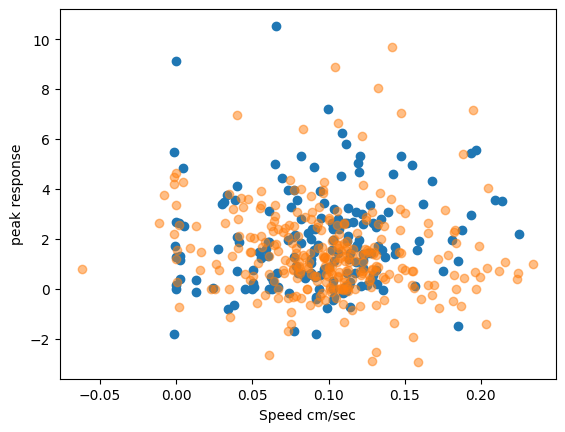

In [234]:
halt_closedloop_data = Vars[(Vars['event'] == 'halt') & (Vars['SessionBlock'] == 'closedloop')]

plt.scatter(halt_closedloop_data['moveX'], halt_closedloop_data['PeakResponse'])

nohalt_closedloop_data = Vars[(Vars['event'] == 'no halt') & (Vars['SessionBlock'] == 'closedloop')]

plt.scatter(nohalt_closedloop_data['moveX'], nohalt_closedloop_data['PeakResponse'], alpha = 0.5)

plt.xlabel('Speed cm/sec')
plt.ylabel('peak response')

In [286]:
# Fit a mixed-effects model
mixed_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",  # Fixed effects
    data=Vars,
    groups=Vars["MouseID"],  # Random intercept for MouseID
).fit()

print(mixed_model.summary())


                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    PeakResponse
No. Observations:      709        Method:                REML        
No. Groups:            5          Scale:                 3.0551      
Min. group size:       123        Log-Likelihood:        -1408.9420  
Max. group size:       160        Converged:             Yes         
Mean group size:       141.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.784    0.213  8.373 0.000  1.367  2.202
event[T.no halt]           -0.398    0.136 -2.925 0.003 -0.665 -0.131
SessionNumber[T.session 2]  0.130    0.133  0.974 0.330 -0.131  0.390
SessionBlock[T.openloop]   -0.099    0.141 -0.702 0.482 -0.376  0.178
Group Var                   0.137   

In [287]:
# Random slopes for 'event' by 'MouseID'
random_slopes_model = smf.mixedlm(
    "PeakResponse ~ event + SessionNumber + SessionBlock",
    data=Vars,
    groups=Vars["MouseID"],
    re_formula="~event"  # Random slope for event within MouseID
).fit()

print(random_slopes_model.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     PeakResponse
No. Observations:      709         Method:                 REML        
No. Groups:            5           Scale:                  3.0523      
Min. group size:       123         Log-Likelihood:         -1408.9129  
Max. group size:       160         Converged:              Yes         
Mean group size:       141.8                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     1.784    0.212  8.423 0.000  1.369  2.199
event[T.no halt]             -0.395    0.147 -2.689 0.007 -0.683 -0.107
SessionNumber[T.session 2]    0.132    0.133  0.990 0.322 -0.129  0.393
SessionBlock[T.openloop]     -0.101    0.141 -0.713 0.476 -0.378  0.176
Group Var

In [290]:
null_model = smf.mixedlm(
    "PeakResponse ~ SessionNumber + SessionBlock",
    data=Vars,
    groups=Vars["MouseID"]
).fit()
print(null_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    PeakResponse
No. Observations:      709        Method:                REML        
No. Groups:            5          Scale:                 3.0885      
Min. group size:       123        Log-Likelihood:        -1412.1245  
Max. group size:       160        Converged:             Yes         
Mean group size:       141.8                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   1.546    0.195  7.936 0.000  1.164  1.928
SessionNumber[T.session 2]  0.119    0.134  0.891 0.373 -0.143  0.381
SessionBlock[T.openloop]   -0.102    0.142 -0.719 0.472 -0.380  0.176
Group Var                   0.132    0.062                           



In [289]:


# Calculate likelihood ratio
ll_null = null_model.llf  # Log-likelihood of the null model
ll_full = mixed_model.llf  # Log-likelihood of the full model
lr_stat = -2 * (ll_null - ll_full)

# Degrees of freedom
df_diff = mixed_model.df_modelwc - null_model.df_modelwc

# p-value
p_value = chi2.sf(lr_stat, df_diff)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-Value: {p_value}")

Likelihood Ratio Test Statistic: 6.364864143484738
Degrees of Freedom: 1
P-Value: 0.011640200711424891


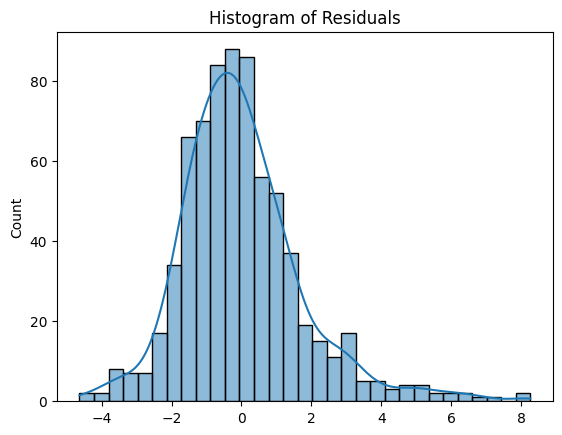

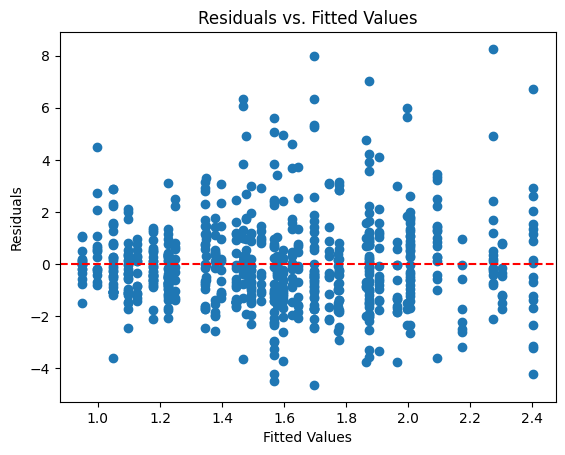

In [293]:
# Extract residuals
residuals = mixed_model.resid

# Histogram of residuals
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Residuals vs. fitted values
fitted_values = mixed_model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

In [56]:
# Function to resample and refit the model
import warnings
from sklearn.exceptions import ConvergenceWarning

def bootstrap_coefficients(model, data, n_bootstraps=1000):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    bootstrap_results = []
    for _ in range(n_bootstraps):
        sample = data.sample(frac=1, replace=True)  # Resample with replacement
        bootstrap_model = smf.mixedlm(
            formula=model.model.formula,
            data=sample,
            groups=sample["MouseID"],
            re_formula="~event"
        ).fit(method='lbfgs', maxiter=100)
        bootstrap_results.append(bootstrap_model.params)
    return pd.DataFrame(bootstrap_results)

# Apply bootstrapping
#bootstrap_results = bootstrap_coefficients(mixed_model, combined_vars)
#print(bootstrap_results.describe())

In [307]:
#Vars.describe()
#bootstrap_results.describe()

In [308]:
interaction_model = smf.mixedlm(
    "PeakResponse ~ event * SessionBlock + SessionNumber",
    data=Vars,
    groups=Vars["MouseID"],
    re_formula="~event"
).fit()

print(interaction_model.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         PeakResponse
No. Observations:           709             Method:                     REML        
No. Groups:                 5               Scale:                      3.0559      
Min. group size:            123             Log-Likelihood:             -1409.1167  
Max. group size:            160             Converged:                  Yes         
Mean group size:            141.8                                                   
------------------------------------------------------------------------------------
                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                  1.814    0.220  8.233 0.000  1.382  2.246
event[T.no halt]                          -0.444    0.175 -2.531 0.011 -0.787 -0.100
Sess

In [312]:
nohalt_model = smf.mixedlm(
    "MeanResponse ~ SessionBlock + SessionNumber",
    data=Nohalt_data,
    groups=Nohalt_data["MouseID"]
).fit()

print(nohalt_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    MeanResponse
No. Observations:      438        Method:                REML        
No. Groups:            5          Scale:                 1.9439      
Min. group size:       62         Log-Likelihood:        -771.2798   
Max. group size:       108        Converged:             Yes         
Mean group size:       87.6                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  -0.133    0.136 -0.974 0.330 -0.400  0.135
SessionBlock[T.openloop]   -0.065    0.143 -0.458 0.647 -0.345  0.214
SessionNumber[T.session 2]  0.237    0.135  1.757 0.079 -0.027  0.500
Group Var                   0.033    0.025                           



/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [313]:
halt_model = smf.mixedlm(
    "MeanResponse ~ SessionBlock + SessionNumber",
    data=halt_data,
    groups=halt_data["MouseID"]
).fit()

print(halt_model.summary())

                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    MeanResponse
No. Observations:      271        Method:                REML        
No. Groups:            5          Scale:                 2.4072      
Min. group size:       48         Log-Likelihood:        -504.9473   
Max. group size:       62         Converged:             No          
Mean group size:       54.2                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.186    0.150  1.241 0.215 -0.108  0.480
SessionBlock[T.openloop]   -0.277    0.200 -1.387 0.166 -0.670  0.115
SessionNumber[T.session 2]  0.378    0.189  1.996 0.046  0.007  0.748
Group Var                   0.000                                    



/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/Users/hildeteigen/opt/anaconda3/envs/aeon/lib/python3.12/site-packages/statsmodels/base/mode